<a href="https://colab.research.google.com/github/newadays/AI-Incubator-Program/blob/main/Forecasting_with_Google_BigQuery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [**Forecasting Pipeline with Google BigQuery**](https://https://cloud.google.com/bigquery/docs/arima-single-time-series-forecasting-tutorial)

Forecasting enables us to predict certain outcomes based on historical data - ([time series](https://towardsdatascience.com/time-series-from-scratch-decomposing-time-series-data-7b7ad0c30fe7/)). Since most of our forecasts will not be accurate, we need to estimate how far our result is from the target. There are several ways to estimate forecasting errors, but some common ones are:

1.   MAE - Mean Absolute Error
2.   RMSE - Root Mean Squared Error
3.   MAPE - Mean Absolute Percentage Error
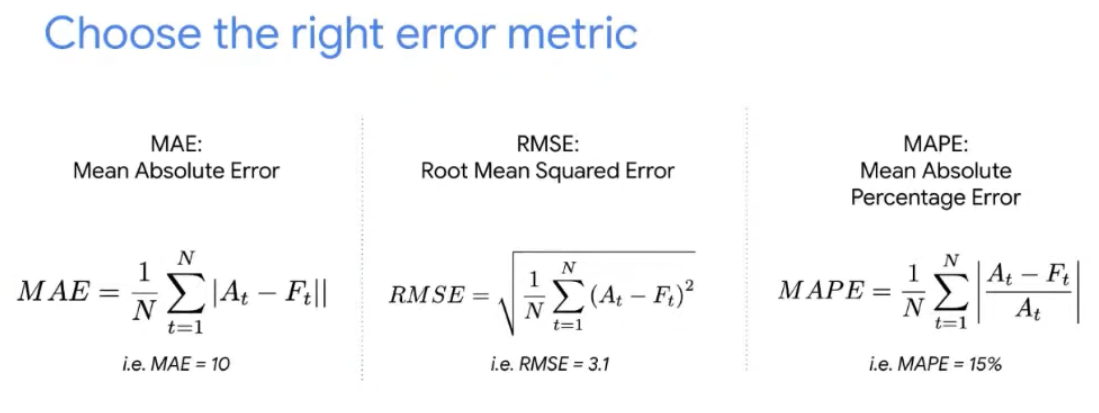

We will be using MAPE error estimates in this walkthrough. To get an intuitive understanding, I have included an Excel file you can download to try to estimate MAPE for the forecast provided and compare your result with the image shown -  [MAPE Practice](https://docs.google.com/spreadsheets/d/15fwqfV0--T_Ia9sbCkB10IzTXZECS5Vy/edit?usp=sharing&ouid=110584949966713652841&rtpof=true&sd=true)
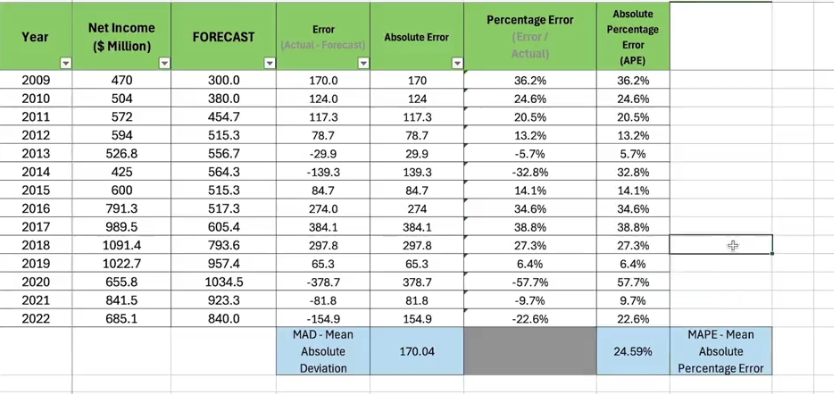

## Overview
There are many ways to perform forecasting, such as [ARIMA](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3#step-3-the-arima-time-series-model), Prophet, linear regression, and more. The focus of this material is to demonstrate how you can approach it for continuous deployment, where new data can arrive and the forecast model is refreshed. Here are the 3 steps - these steps can be iterative.

1.   Exploratory Data Analysis (EDA)
2.   Build and Evaluate your model
3.   Forecast for new data



In [ ]:
#@title Install Latest Version of Some Packages
# !pip install --upgrade google-cloud-bigquery
# !pip install --upgrade google-cloud-bigquery-storage
# !pip install --upgrade google-cloud-core
# !pip install --upgrade chart_studio
# !pip install --upgrade pandasql

You may need to restart. Uncomment the first cell and Click on the "Runtime" on the main menu and click Restart Session

In [ ]:
#@title Import Python Libraries & Some Other Setup
# Basic Python data science libraries
import pandas as pd
import pandas_gbq
import numpy as np
import scipy.optimize

# Import and setup for plotly in Colab
import chart_studio
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.io as pio

# Enable extension package to display pandas data frames as interactive tables
%load_ext google.colab.data_table

The authentication step in the next cell will require manually going

*   to Google
*   Authenticate

through some pop-up screens and copy/pasting an authentication code from another window back into the cell to complete (on the 1st run; may run automatically thereafter).

In [ ]:
#@title Provide Google Credentials to Colab Runtime (May Require Manually Copy/Pasting Authentication Code)
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


##Please enter your own GCP/BigQuery project ID in the form below, then run the cell to set up the BigQuery client.

If you don’t already have a GCP project, there are [2 free options available](https://cloud.google.com/bigquery/):

1. For BigQuery specifically, sign up for [BigQuery sandbox](https://cloud.google.com/blog/products/data-analytics/query-without-a-credit-card-introducing-bigquery-sandbox) (1 TB query, 10 GB storage capacity per month).
2. If you want to experiment with multiple GCP products, activate the [free trial](https://cloud.google.com/free/) ($300 credit for up to 12 months).

In [ ]:
#@title Enter GCP/BigQuery Project ID
project_id = 'my-gcp-project' #@param{type:"string"}
location_id = 'us-central1' #@param{type:"string"}

# Packages used for interfacing w/ BigQuery from Python
from google.cloud import bigquery

# Create BigQuery client
bq_client = bigquery.Client(project = project_id, location=location_id)

In [ ]:
# Test Connection to BigQuery
def bigquery_connection(query):
    try:
        # Simple test query
        print("Query", query)
        results = bq_client.query_and_wait(query)
        print("Connection successful!")
        for row in results:
            print(f"Test value: {row.test_value}")
        return True
    except Exception as e:
        print(f"Connection failed: {e}")
        return False

In [ ]:
# Test the connection - return true if working correctly
sqlquery = """
            SELECT 1 as test_value
        """
bigquery_connection(sqlquery)

Connection successful!
Test value: 1


True

Import some libraries for Analysis and EDA

In [ ]:
import numpy as np
import pandas as pd
import pandasql as ps
import math
import itertools

#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#matplotlib setting defaults
sns.set(font="Arial",
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "dimgrey",
 "xtick.bottom": False,
 "xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})

#Data Exploration: Examine Daily Sales Data across stores
----
In this section, we look at how to get daily sales data for different stores across Ecuador - data ranges between 2013 and 2017:

You will need to take the following steps for us to process the data:
* Download the [Store Sales Data from Kaggle](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data?select=train.csv)
* Unzip the file
* Upload the CSV to the notebook using the Folder button
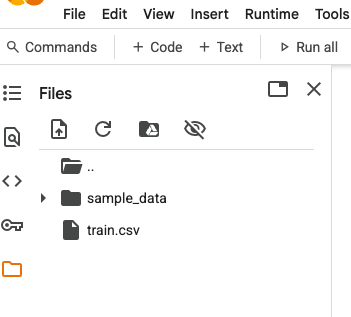

In [ ]:
df = pd.read_csv('train.csv')
df.columns = df.columns.str.replace(' ', '_').str.lower()

df['date'] = pd.to_datetime(df['date'], format= "%Y-%m-%d")

In [ ]:
min(df['date']), max(df['date'])

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [ ]:
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0
1,1,2013-01-01,1,BABY CARE,0.00,0
2,2,2013-01-01,1,BEAUTY,0.00,0
3,3,2013-01-01,1,BEVERAGES,0.00,0
4,4,2013-01-01,1,BOOKS,0.00,0


Let's aggregate the dataset to the "family" and "sales" daily level so that we can have high volume metrics for demand forecasting throughout the country. The line of code below can also be done in SQL. select date, family, sum(sales) from df group by date, family

In [ ]:
agg_df = df.groupby(['date','family']).agg({'sales':'sum'}).reset_index().sort_values(['family','date'])

In [ ]:
agg_df.head()

,date,family,sales
0,2013-01-01,AUTOMOTIVE,0.00
33,2013-01-02,AUTOMOTIVE,255.00
66,2013-01-03,AUTOMOTIVE,161.00
99,2013-01-04,AUTOMOTIVE,169.00
132,2013-01-05,AUTOMOTIVE,342.00


In [ ]:
def create_stacked_area_chart_seaborn(df):
    """
    Create a stacked area chart using seaborn styling
    """
    # Set style
    plt.style.use('seaborn-v0_8')  # or just 'seaborn' for older versions

    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Pivot the data
    pivot_df = df.pivot_table(index='date', columns='family', values='sales', fill_value=0)

    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 8))

    # Create stacked area chart with custom colors
    colors = plt.cm.tab20(np.linspace(0, 1, len(pivot_df.columns)))

    ax.stackplot(pivot_df.index, *[pivot_df[col] for col in pivot_df.columns],
                labels=pivot_df.columns, colors=colors, alpha=0.8)

    # Customize the plot
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Sales', fontsize=12)
    ax.set_title('Sales Data for All Product Families Over Time', fontsize=16, fontweight='bold', pad=20)

    # Format y-axis
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

    # Add legend with better positioning
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9, frameon=True, fancybox=True, shadow=True)

    # Add grid for better readability
    ax.grid(True, alpha=0.3)

    # Format x-axis
    ax.tick_params(axis='x', rotation=0)

    # Adjust layout
    plt.tight_layout()

    return fig, ax

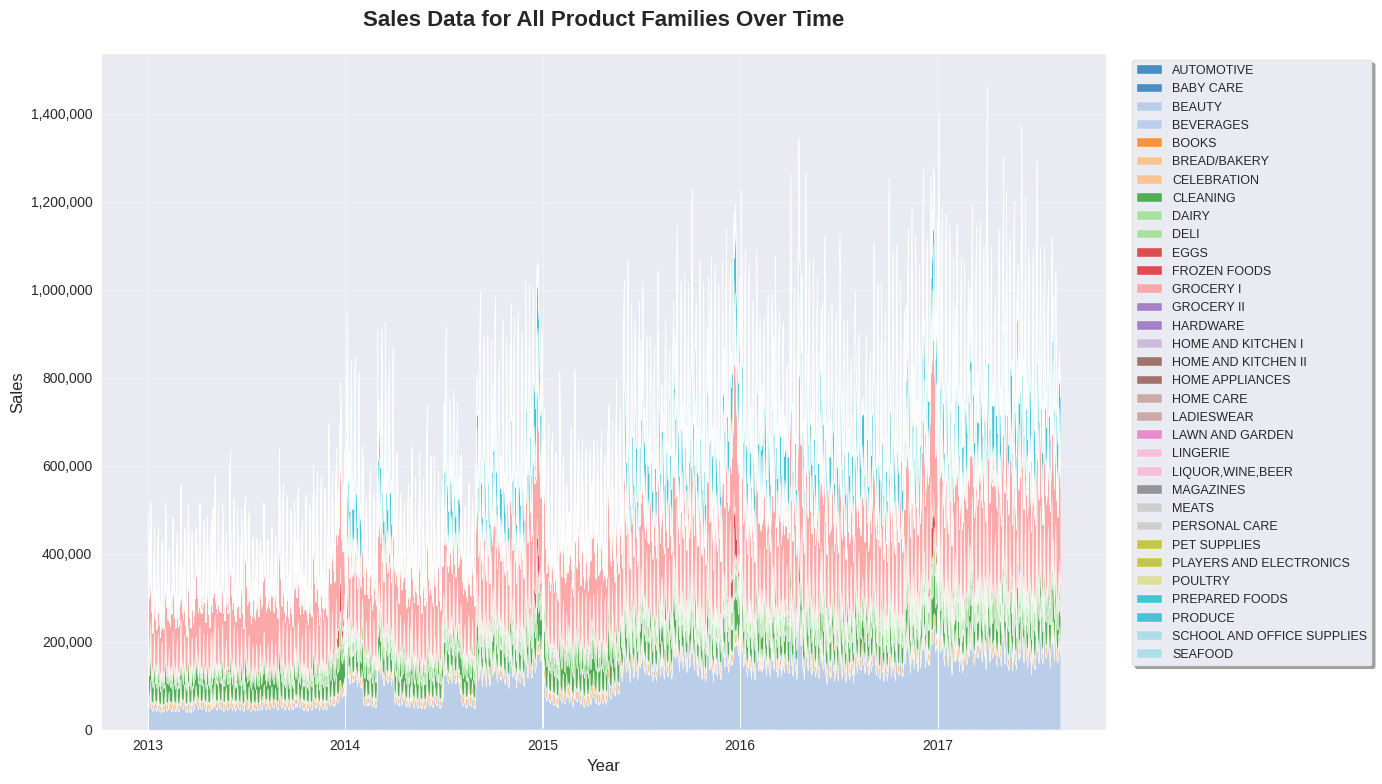

In [ ]:
# with seaborn styling:
fig, ax = create_stacked_area_chart_seaborn(agg_df)

You may notice some seasonality in the data

In [ ]:
total_sales_df = agg_df.pivot(index='date',columns='family', values='sales')
total_sales_df.head()

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,EGGS,FROZEN FOODS,GROCERY I,GROCERY II,HARDWARE,HOME AND KITCHEN I,HOME AND KITCHEN II,HOME APPLIANCES,HOME CARE,LADIESWEAR,LAWN AND GARDEN,LINGERIE,"LIQUOR,WINE,BEER",MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.00,0.00,2.00,810.00,0.00,180.59,0.00,186.00,143.00,71.09,46.00,29.65,700.00,15.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,5.00,105.00,0.00,110.80,25.00,0.00,0.00,42.64,37.85,0.00,0.00,0.00
2013-01-02,255.00,0.00,207.00,72092.00,0.00,26246.32,0.00,74629.00,23381.00,15754.50,10932.00,7115.39,202020.00,1476.00,46.00,0.00,0.00,21.00,0.00,0.00,121.00,469.00,2411.00,0.00,20871.46,17204.00,0.00,0.00,13975.88,5338.11,0.00,0.00,1526.75
2013-01-03,161.00,0.00,125.00,52105.00,0.00,18456.48,0.00,55893.00,18001.00,11172.45,7358.00,4760.81,144878.00,1048.00,37.00,0.00,0.00,15.00,0.00,0.00,83.00,366.00,2476.00,0.00,16597.40,12568.00,0.00,0.00,10674.39,3591.39,0.00,0.00,1094.31
2013-01-04,169.00,0.00,133.00,54167.00,0.00,16721.97,0.00,52064.00,18148.00,10143.21,6760.00,4525.93,135754.00,1031.00,57.00,0.00,0.00,13.00,0.00,0.00,127.00,382.00,4796.00,0.00,21625.96,11303.00,0.00,0.00,10772.52,4472.97,0.00,0.00,1293.12
2013-01-05,342.00,0.00,191.00,77818.00,0.00,22367.76,0.00,70128.00,23082.00,13734.95,8576.00,5781.61,188356.00,1273.00,87.00,0.00,0.00,11.00,0.00,0.00,180.00,458.00,6715.00,0.00,20879.09,16819.00,0.00,0.00,13475.01,5830.07,0.00,0.00,1245.64


In [ ]:
# @title Create a Dataset for the BigQuery Forecast model Training
dataset_id = "forecasting" # @param {"type":"string","placeholder":"forecasting"}

sqlquery = f"""
            CREATE SCHEMA IF NOT EXISTS `{project_id}.{dataset_id}`
OPTIONS (
    location='{location_id}',
    description='Dataset for the BigQuery Forecast model Training'
)
        """
bigquery_connection(sqlquery)

In [ ]:
# @title Write Training data into BigQuery Dataset Table
table_id = "ecuador-store-sales-cleaned" #@param{type:"string"}
# Backtest propagation - -- Train on data up to Nov 27, 2014 (2014-11-27)
# Step 1: Write the dataframe into Google Cloud BigQuery
def write_dataframe_to_bq(df, table_id, project_id=project_id):
    """
    Basic method to write DataFrame to BigQuery

    Args:
        df: pandas DataFrame
        table_id: 'dataset.table_name' format
        project_id: Google Cloud project ID
    """

    # Full table reference
    full_table_id = f"{dataset_id}.{table_id}"
    print(f"Writing to {full_table_id}")

    try:
        # Write DataFrame to BigQuery
        job = pandas_gbq.to_gbq(df, full_table_id, project_id=project_id)
        job.result()  # Wait for the job to complete

        print(f"Successfully loaded {len(df)} rows to {full_table_id}")

    except Exception as e:
        print(f"Error loading data: {e}")

print("\nStep 1: Creating training data for forecasting model...")
write_dataframe_to_bq(agg_df, table_id, project_id=project_id)


In [ ]:
# Backtest propagation - -- Train on data up to Nov 27, 2014 (2014-11-27)
# Step 2: Create a model trained on data excluding the last 30 days
def create_backtest_model():
    query = f"""
    CREATE OR REPLACE MODEL `{dataset_id}.arima_model_backtest`
    OPTIONS(
      model_type='ARIMA_PLUS',
      time_series_timestamp_col='date',
      time_series_data_col='sales',
      time_series_id_col='family'
    ) AS
    SELECT
      date,
      family,
      sales
    FROM `{project_id}.{dataset_id}.{table_id}`
    WHERE date < '2014-11-27'
    """

    try:
        print("Creating backtest model...")
        print("query", query)
        query_job = bq_client.query(query)
        query_job.result()  # Wait for completion
        print("Model created successfully!")

    except Exception as e:
        print(f"Model creation failed: {e}")

print("\nStep 2: Creating backtest forecasting model...")
create_backtest_model()

In [ ]:
# Step 3: Your Evaluation Query with Proper Error Handling
def run_evaluation_query():
    query = f"""
    SELECT *
    FROM ML.EVALUATE(
      MODEL `{dataset_id}.arima_model_backtest`,
      (
        SELECT
          date,
          family,
          sales
        FROM `{project_id}.{dataset_id}.{table_id}`
        WHERE date >= '2014-11-27'  -- Last 30 days of your data
          AND date <= '2014-12-27'  -- End of your available data
      )
    )
    """

    try:
        print("Running evaluation query...")
        query_job = bq_client.query(query)
        results = query_job.result()

        print("Query completed successfully!")
        print("\nEvaluation Results:")
        print("-" * 50)

        for row in results:
            print(f"Family: {row.family}")
            print(f"MAE: {row.mean_absolute_error}")
            print(f"RMSE: {row.root_mean_squared_error}")
            print(f"MAPE: {row.mean_absolute_percentage_error}")
            print("-" * 30)

    except Exception as e:
        print(f"Query failed: {e}")
        print("\nTroubleshooting steps:")
        print("1. Check if the model exists")
        print("2. Verify table names and project references")
        print("3. Check permissions")

print("\nStep 3: Running evaluation...")
run_evaluation_query()

In [ ]:
# Step 4: Generate forecasts after 2014-11-27 for up to 30 days
def forecast_sales_simple(project_id: str, dataset_id: str):
    """
    Simplified version of forecast function with your original parameters

    Args:
        project_id (str): Google Cloud Project ID
        dataset_id (str): BigQuery dataset name

    Returns:
        pd.DataFrame: Forecast results or None if error occurs
    """

    client = bigquery.Client(project=project_id)

    sqlquery = f"""
    SELECT
        forecast_timestamp as date,
        forecast_value as predicted_sales,
        standard_error,
        confidence_level,
        prediction_interval_lower_bound,
        prediction_interval_upper_bound
    FROM
        ML.FORECAST(MODEL `{project_id}.{dataset_id}.arima_model_backtest`,
            STRUCT(30 AS horizon, -- 30 days forecast
                   0.95 AS confidence_level))
    WHERE forecast_timestamp > '2014-11-27'
    ORDER BY forecast_timestamp;
    """

    try:
        df = client.query(sqlquery).to_dataframe()
        return df
    except Exception as e:
        print(f"Error: {e}")
        return None


simple_forecast = forecast_sales_simple(project_id, dataset_id)

In [ ]:
print("\nForecast Results:")
print(simple_forecast.head())
print(f"\nDataFrame shape: {simple_forecast.shape}")
print(f"Date range: {simple_forecast['date'].min()} to {simple_forecast['date'].max()}")

## Final Steps

You can plug these code into a [container and schedule](https://cloud.google.com/run/docs/integrate-functions-with-cloud-databases) them to run daily to provide forecast for a supply operation.

In this lab, we examine how to perform forecasting using ARIMA method and operationalize with Google Cloud BigQuery.